## Import necessary libraries

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from shutil import copyfile
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

DATA_ROOT = "C:\\Users\\Student\\Desktop\\Kamilio\\data\\Br35H\\"


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

## Split data into separate folders
Out of total 3000 samples:
- 10% for test set
- 10% for val set
- 20% for classificator training

- 60% for pre-text task

Same test and val sets will be used for pre-text task and classifictor training

In [19]:
def get_data_paths():
    categories = os.listdir(os.path.join(DATA_ROOT, 'Br35H_for_classification'))
    X = []
    Y = []
    for category in categories:
        category_path = os.path.join(DATA_ROOT, category)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(DATA_ROOT, category, image_name)
            X.append(image_path)
            Y.append(category)    
    return X, Y

In [20]:
def copy_data(X, Y, folder_name):
    os.mkdir(os.path.join(DATA_ROOT,folder_name))
    for category in set(Y):
        os.mkdir(os.path.join(DATA_ROOT,folder_name,category))
    for src, category in zip(X, Y):
        image_name = os.path.split(src)[1]
        dst = os.path.join(DATA_ROOT, folder_name, category, image_name)
        copyfile(src, dst)

In [21]:
X, Y = get_data_paths()

In [22]:
X_train, X_test_val, Y_train, Y_test_val = train_test_split(X, Y, train_size=0.80,random_state=1, stratify = Y)
X_test, X_val, Y_test, Y_val = train_test_split(X_test_val, Y_test_val, train_size=0.50,random_state=1, stratify = Y_test_val)
pre_text_size = 0.6/0.8
X_pre_text, X_train, Y_pre_text, Y_train = train_test_split(X_train, Y_train, train_size=pre_text_size,random_state=1, stratify = Y_train)

In [23]:
copy_data(X_test,Y_test,folder_name = 'test')
copy_data(X_val,Y_val,folder_name = 'val')
copy_data(X_train,Y_train,folder_name = 'train')
copy_data(X_pre_text,Y_pre_text,folder_name = 'pre_text')

## Create dataset for pre-text task

In [3]:
def load_dataset(dataset_folder: str):
    categories = os.listdir(os.path.join(DATA_ROOT, dataset_folder))
    X = []
    Y = []
    for category in categories:
        category_path = os.path.join(DATA_ROOT,dataset_folder,category)
        category_index = categories.index(category)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(DATA_ROOT,dataset_folder, category, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (128, 128))
            X.append(image)
            Y.append(category_index) 
            
    return X, Y

In [4]:
def write_dataset(X, Y, folder_name):
    i=0
    os.mkdir(os.path.join(DATA_ROOT,folder_name))
    for category in set(Y):
        os.mkdir(os.path.join(DATA_ROOT,folder_name,str(category)))
        
    for image, category in zip(X, Y):
        image_name = str(category)+"_"+str(i)
        i+=1
        dst = os.path.join(DATA_ROOT, folder_name, str(category), image_name+'.jpg')
        cv2.imwrite(dst, image)

In [94]:
# X, Y = load_dataset("val")
# X=np.array(X).reshape(-1, 128, 128, 3)
# write_dataset(X,Y,'val_reshaped')

{0, 1}


In [4]:
X_pre_text, Y_pre_text = load_dataset('pre_text')
X_pre_text=np.array(X_pre_text).reshape(-1, 128, 128, 3)

In [5]:
pre_text_len = len(X_pre_text)
# X_train_0 dataset will contain images rotated by 0 degrees(No rotation)
X_train_0=X_pre_text.copy()

# X_train_90 dataset will contain images rotated by 90 degrees
X_train_90=np.rot90(X_pre_text, axes=(1,2))

# X_train_180 dataset will contain images rotated by 180 degrees
X_train_180=np.rot90(X_pre_text, 2, axes=(1,2))

# X_train_270 dataset will contain images rotated by 270 degrees
X_train_270=np.rot90(X_pre_text, 3, axes=(1,2))

# Assigning pseudo-labels to rotated image datasets
Y_train_0=np.full(pre_text_len, 0)
Y_train_90=np.full(pre_text_len, 1)
Y_train_180=np.full(pre_text_len, 2)
Y_train_270=np.full(pre_text_len, 3)

In [6]:
# Concatenating Datasets
X_train_unlabeled_full=np.concatenate((X_train_0, X_train_90, X_train_180, X_train_270), axis=0)
Y_train_unlabeled_full=np.concatenate((Y_train_0, Y_train_90, Y_train_180, Y_train_270), axis=0)

In [7]:
X_rot_train, X_rot_val, Y_rot_train, Y_rot_val = train_test_split(X_train_unlabeled_full, Y_train_unlabeled_full, train_size=0.80, stratify = Y_train_unlabeled_full)

In [45]:
write_dataset(X_rot_train, Y_rot_train, "rot_train")
write_dataset(X_rot_val, Y_rot_val, "rot_val")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\Student\\Desktop\\Kamilio\\data\\Br35H\\rot_train'

# Train model on pre-text task 

## Load data

In [3]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return int(one_hot)

In [4]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize and norm the image
    img = tf.image.resize(img, [128, 128])
    img = img / 255.0
    return img

In [5]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [6]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
MINI_BATCH_SIZE = 32
class_names = ['0', '1', '2', '3']

rot_train_dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\rot_train\\*\\*", shuffle=False)
rot_train_dataset = rot_train_dataset.shuffle(len(rot_train_dataset), reshuffle_each_iteration=False)
rot_train_dataset = rot_train_dataset.map(process_path, num_parallel_calls=AUTOTUNE).batch(MINI_BATCH_SIZE)

rot_val_dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\rot_val\\*\\*", shuffle=False)
rot_val_dataset = rot_val_dataset.shuffle(len(rot_val_dataset), reshuffle_each_iteration=False)
rot_val_dataset = rot_val_dataset.map(process_path, num_parallel_calls=AUTOTUNE).batch(MINI_BATCH_SIZE)

In [7]:
MINI_BATCH_SIZE = 32
class_names = ['0', '1']

train_dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\train_reshaped\\*\\*", shuffle=False)
train_dataset = train_dataset.shuffle(len(train_dataset), reshuffle_each_iteration=False)
train_dataset = train_dataset.map(process_path, num_parallel_calls=AUTOTUNE).batch(MINI_BATCH_SIZE)

val_dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\val_reshaped\\*\\*", shuffle=False)
val_dataset = val_dataset.shuffle(len(val_dataset), reshuffle_each_iteration=False)
val_dataset = val_dataset.map(process_path, num_parallel_calls=AUTOTUNE).batch(MINI_BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\test_reshaped\\*\\*", shuffle=False)
test_dataset = test_dataset.shuffle(len(test_dataset), reshuffle_each_iteration=False)
test_dataset = test_dataset.map(process_path, num_parallel_calls=AUTOTUNE).batch(MINI_BATCH_SIZE)

In [8]:
tmp=iter(rot_train_dataset)

In [9]:
tmp1=next(tmp)

In [10]:
tmp1[1]

<tf.Tensor: shape=(32, 4), dtype=int32, numpy=
array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])>

## Initialize model

In [11]:
# model = keras.models.Sequential([
#         keras.layers.Conv2D(64, 7, activation="relu", padding="same",
#                             input_shape=[128, 128, 3]),
#         keras.layers.MaxPooling2D(2),
#         keras.layers.Conv2D(2, 3, activation="relu", padding="same"),
#         keras.layers.Conv2D(2, 3, activation="relu", padding="same"),
#         keras.layers.MaxPooling2D(2),
#         keras.layers.Conv2D(4, 3, activation="relu", padding="same"),
#         keras.layers.Conv2D(4, 3, activation="relu", padding="same"),
#         keras.layers.MaxPooling2D(2),
#         keras.layers.Flatten(),
#         keras.layers.Dense(4, activation="relu"),
#         keras.layers.Dropout(0.5),
#         keras.layers.Dense(4, activation="relu"),
#         keras.layers.Dropout(0.5),
#         keras.layers.Dense(4, activation="softmax")
# ])

In [12]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras import layers

# IMG_SIZE=224
# NUM_CLASSES=4

# inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# outputs = EfficientNetB0(include_top=False, weights=None, classes=NUM_CLASSES)(inputs)

# model = tf.keras.Model(inputs, outputs)

# # Compiling the model
# model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers

IMG_SIZE=128
NUM_CLASSES=4

def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights=None)

    # Freeze the pretrained weights
    # model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [12]:
model = build_model()
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 129, 129, 3)  0           ['normalization[0][0]'

 block2b_expand_bn (BatchNormal  (None, 32, 32, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 32, 32, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2b_dwconv (DepthwiseConv2  (None, 32, 32, 144)  1296       ['block2b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2b_bn (BatchNormalization  (None, 32, 32, 144)  576        ['block2b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 16, 16, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_activation (Activation  (None, 16, 16, 240)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
          

                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block4b_se_reshape[0][0]']     
                                                                                                  
 block4b_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block4b_se_reduce[0][0]']      
                                                                                                  
 block4b_s

                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_se_excite (Multiply)   (None, 8, 8, 480)    0           ['block5a_activation[0][0]',     
                                                                  'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_project_conv (Conv2D)  (None, 8, 8, 112)    53760       ['block5a_se_excite[0][0]']      
                                                                                                  
 block5a_p

 block5c_project_bn (BatchNorma  (None, 8, 8, 112)   448         ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 8, 8, 112)    0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_add (Add)              (None, 8, 8, 112)    0           ['block5c_drop[0][0]',           
                                                                  'block5b_add[0][0]']            
                                                                                                  
 block6a_expand_conv (Conv2D)   (None, 8, 8, 672)    75264       ['block5c_add[0][0]']            
                                                                                                  
 block6a_e

                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 4, 4, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 4, 4, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6c_expand_activation (Act  (None, 4, 4, 1152)  0           ['block6c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6c_dwconv (DepthwiseConv2  (None, 4, 4, 1152)  28800       ['block6c_expand_activation[0][0]
 D)       

                                                                                                  
 block7a_expand_activation (Act  (None, 4, 4, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 4, 4, 1152)  10368       ['block7a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block7a_bn (BatchNormalization  (None, 4, 4, 1152)  4608        ['block7a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block7a_a

## Train model on pre-text task 

In [26]:
import matplotlib.pyplot as plt


def plot_acc(hist, title: str):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(title)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
def plot_loss(hist, title: str):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title(title)
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [15]:
history = model.fit(rot_train_dataset, epochs=100, validation_data=rot_val_dataset)

Epoch 1/100
180/180 [==============================] - 18s 100ms/step - loss: 1.4916 - accuracy: 0.3548 - val_loss: 1.3888 - val_accuracy: 0.2500
Epoch 2/100
180/180 [==============================] - 16s 91ms/step - loss: 1.1037 - accuracy: 0.4453 - val_loss: 1.6959 - val_accuracy: 0.2500
Epoch 3/100
180/180 [==============================] - 16s 91ms/step - loss: 0.9426 - accuracy: 0.4845 - val_loss: 1.2702 - val_accuracy: 0.3458
Epoch 4/100
180/180 [==============================] - 16s 91ms/step - loss: 0.8831 - accuracy: 0.4882 - val_loss: 0.8322 - val_accuracy: 0.4757
Epoch 5/100
180/180 [==============================] - 16s 91ms/step - loss: 0.8554 - accuracy: 0.4979 - val_loss: 1.2047 - val_accuracy: 0.4979
Epoch 6/100
180/180 [==============================] - 16s 91ms/step - loss: 0.8540 - accuracy: 0.4984 - val_loss: 1.1187 - val_accuracy: 0.4812
Epoch 7/100
180/180 [==============================] - 16s 90ms/step - loss: 0.7904 - accuracy: 0.4946 - val_loss: 0.7931 - val_a

180/180 [==============================] - 16s 90ms/step - loss: 0.7338 - accuracy: 0.5596 - val_loss: 1.0066 - val_accuracy: 0.5097
Epoch 58/100
180/180 [==============================] - 16s 90ms/step - loss: 0.7472 - accuracy: 0.5695 - val_loss: 1.0234 - val_accuracy: 0.4972
Epoch 59/100
180/180 [==============================] - 16s 90ms/step - loss: 0.7323 - accuracy: 0.5778 - val_loss: 0.8818 - val_accuracy: 0.4972
Epoch 60/100
180/180 [==============================] - 16s 90ms/step - loss: 0.7303 - accuracy: 0.5940 - val_loss: 0.7776 - val_accuracy: 0.4951
Epoch 61/100
180/180 [==============================] - 16s 90ms/step - loss: 0.7275 - accuracy: 0.5879 - val_loss: 0.7397 - val_accuracy: 0.5167
Epoch 62/100
180/180 [==============================] - 16s 90ms/step - loss: 0.7257 - accuracy: 0.5707 - val_loss: 0.7400 - val_accuracy: 0.5139
Epoch 63/100
180/180 [==============================] - 16s 90ms/step - loss: 0.7107 - accuracy: 0.5853 - val_loss: 1.2310 - val_accuracy

In [16]:
model.save("C:\\Users\\Student\\Desktop\\Kamilio\\models\\model_v1.0.0")

INFO:tensorflow:Assets written to: C:\Users\Student\Desktop\Kamilio\models\Br35H_rot_128_128_3_v1.0.0\assets


INFO:tensorflow:Assets written to: C:\Users\Student\Desktop\Kamilio\models\Br35H_rot_128_128_3_v1.0.0\assets


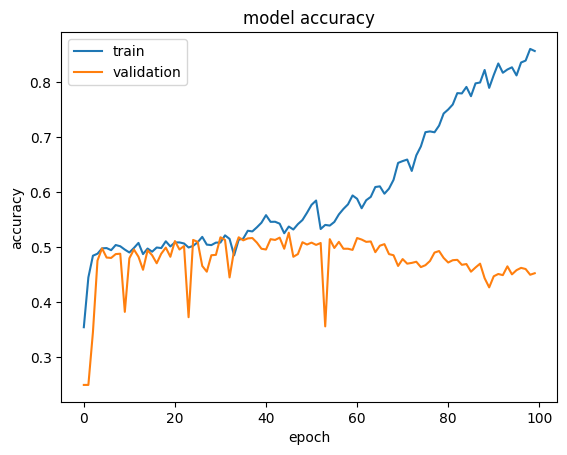

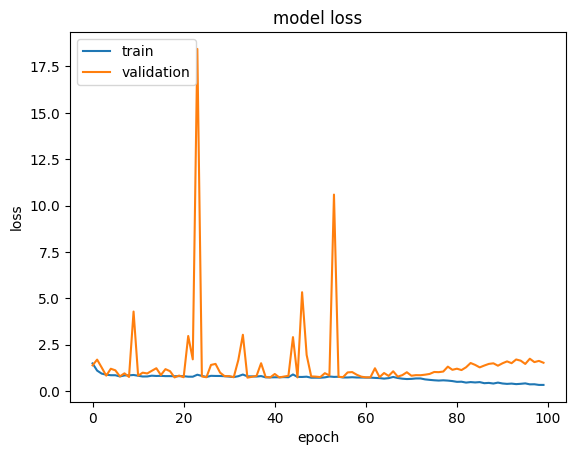

In [17]:
plot_acc(history, "pre-text task model accuracy")
plot_loss(history, "pre-text task model loss ")

## Fine-tune pretrained model

In [32]:
model = tf.keras.models.load_model("C:\\Users\\Student\\Desktop\\Kamilio\\models\\model_v1.0.0")

In [18]:
inputs = model.input

x = model.layers[-2].output
outputs = layers.Dense(2, activation="softmax", name="pred")(x)

model2 = tf.keras.Model(inputs, outputs, name="EfficientNet_2")

In [19]:
model2.summary()

Model: "EfficientNet_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 129, 129, 3)  0           ['normalization[0][0

 block2b_expand_bn (BatchNormal  (None, 32, 32, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 32, 32, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2b_dwconv (DepthwiseConv2  (None, 32, 32, 144)  1296       ['block2b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2b_bn (BatchNormalization  (None, 32, 32, 144)  576        ['block2b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 16, 16, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_activation (Activation  (None, 16, 16, 240)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
          

                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block4b_se_reshape[0][0]']     
                                                                                                  
 block4b_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block4b_se_reduce[0][0]']      
                                                                                                  
 block4b_s

                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_se_excite (Multiply)   (None, 8, 8, 480)    0           ['block5a_activation[0][0]',     
                                                                  'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_project_conv (Conv2D)  (None, 8, 8, 112)    53760       ['block5a_se_excite[0][0]']      
                                                                                                  
 block5a_p

 block5c_project_bn (BatchNorma  (None, 8, 8, 112)   448         ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 8, 8, 112)    0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_add (Add)              (None, 8, 8, 112)    0           ['block5c_drop[0][0]',           
                                                                  'block5b_add[0][0]']            
                                                                                                  
 block6a_expand_conv (Conv2D)   (None, 8, 8, 672)    75264       ['block5c_add[0][0]']            
                                                                                                  
 block6a_e

                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 4, 4, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 4, 4, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6c_expand_activation (Act  (None, 4, 4, 1152)  0           ['block6c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6c_dwconv (DepthwiseConv2  (None, 4, 4, 1152)  28800       ['block6c_expand_activation[0][0]
 D)       

                                                                                                  
 block7a_expand_activation (Act  (None, 4, 4, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 4, 4, 1152)  10368       ['block7a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block7a_bn (BatchNormalization  (None, 4, 4, 1152)  4608        ['block7a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block7a_a

In [20]:
# Freezing the Convolutional Layers while keeping Dense layers as Trainable
for layer in model2.layers:
    if not (layer.name in ['pred', 'batch_normalization']):
        layer.trainable=False
    else:
        layer.trainable=True

In [21]:
# Compiling the model
model2.compile(loss="categorical_crossentropy",  optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

In [22]:
# Training the model on Downstream Task
history = model2.fit(train_dataset, validation_data=val_dataset, epochs=100)

Epoch 1/100
19/19 [==============================] - 7s 133ms/step - loss: 0.7029 - accuracy: 0.5524 - val_loss: 0.6929 - val_accuracy: 0.5267
Epoch 2/100
19/19 [==============================] - 1s 40ms/step - loss: 0.6709 - accuracy: 0.6273 - val_loss: 0.6768 - val_accuracy: 0.5633
Epoch 3/100
19/19 [==============================] - 1s 40ms/step - loss: 0.6596 - accuracy: 0.6290 - val_loss: 0.6860 - val_accuracy: 0.5400
Epoch 4/100
19/19 [==============================] - 1s 40ms/step - loss: 0.6584 - accuracy: 0.6173 - val_loss: 0.6781 - val_accuracy: 0.5700
Epoch 5/100
19/19 [==============================] - 1s 40ms/step - loss: 0.6592 - accuracy: 0.6256 - val_loss: 0.6781 - val_accuracy: 0.5800
Epoch 6/100
19/19 [==============================] - 1s 40ms/step - loss: 0.6609 - accuracy: 0.6223 - val_loss: 0.6727 - val_accuracy: 0.5867
Epoch 7/100
19/19 [==============================] - 1s 40ms/step - loss: 0.6431 - accuracy: 0.6273 - val_loss: 0.6696 - val_accuracy: 0.6067
Epoch

19/19 [==============================] - 1s 39ms/step - loss: 0.6279 - accuracy: 0.6639 - val_loss: 0.6000 - val_accuracy: 0.6533
Epoch 59/100
19/19 [==============================] - 1s 39ms/step - loss: 0.6130 - accuracy: 0.6755 - val_loss: 0.5942 - val_accuracy: 0.6733
Epoch 60/100
19/19 [==============================] - 1s 39ms/step - loss: 0.6217 - accuracy: 0.6889 - val_loss: 0.5960 - val_accuracy: 0.6667
Epoch 61/100
19/19 [==============================] - 1s 39ms/step - loss: 0.6166 - accuracy: 0.6689 - val_loss: 0.5992 - val_accuracy: 0.6700
Epoch 62/100
19/19 [==============================] - 1s 39ms/step - loss: 0.6167 - accuracy: 0.6822 - val_loss: 0.5983 - val_accuracy: 0.6733
Epoch 63/100
19/19 [==============================] - 1s 40ms/step - loss: 0.6184 - accuracy: 0.6755 - val_loss: 0.5989 - val_accuracy: 0.6633
Epoch 64/100
19/19 [==============================] - 1s 39ms/step - loss: 0.6125 - accuracy: 0.6772 - val_loss: 0.6023 - val_accuracy: 0.6500
Epoch 65/100

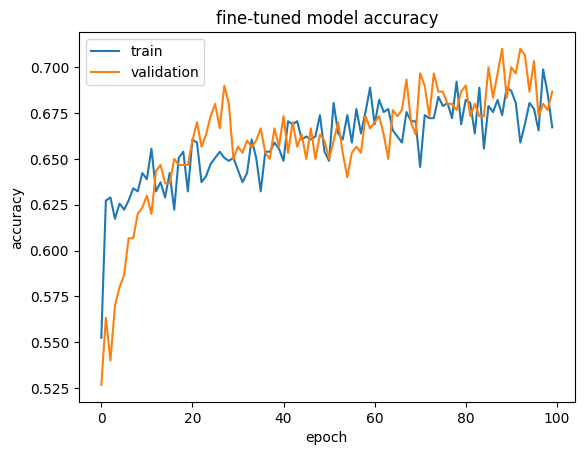

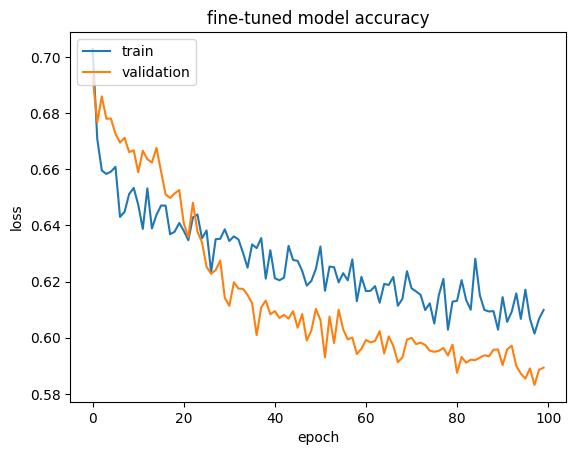

In [27]:
plot_acc(history, "fine-tuned model accuracy")
plot_loss(history, "fine-tuned model accuracy")

In [24]:
model2.evaluate(test_dataset)

10/10 [==============================] - 0s 24ms/step - loss: 0.6070 - accuracy: 0.6833


[0.6070020794868469, 0.6833333373069763]

In [25]:
model2.save("C:\\Users\\Student\\Desktop\\Kamilio\\models\\model_v1.0.1")

INFO:tensorflow:Assets written to: C:\Users\Student\Desktop\Kamilio\models\model_v1.0.1\assets


INFO:tensorflow:Assets written to: C:\Users\Student\Desktop\Kamilio\models\model_v1.0.1\assets
